# Regression
### 1. Reading the Dataset ¶ 

In [1039]:
import pandas as pd
df_real_estate = pd.read_csv('real-estate-regression.csv')
# df_real_estate.head()

### 2. Overview
Columns:
* **id** - id of the data row
* **Вулиця** - the name of the street
* **Район** - the area of the city
* **Місто** - the city
* **Область** - the city area
* **Дата** - the date of the estate being posted on the data base
* **Тип нерухомості** - the type of the real estate
* **Ціна** - the price
* **Тип ціни** - the currency
* **Кімнат** - the number of rooms
* **Поверх** - the floor of the real estate
* **Поверховість** - the number of the floors in the estate
* **Загальна площа** - the area of the estate
* **Житлова площа** - the area of the estate inside
* **Кухня** - the kitchen area
* **Стіни** - the walls material
* **Назва** - the name of the real estate
* **Соток** - the area (1 sotka = 10 x 10 = 100 m2)
* **Агенція** - the agency of the real estate
* **Користувач** - the person or the agency that is selling
* **Телефон** - the phone number
* **Опис** - the description of the real estate

In [1040]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# regression models
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.pipeline import Pipeline # for using pipeline
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.preprocessing import PolynomialFeatures # for adding polynomial features
from sklearn.linear_model import Ridge # for ridge regression
from sklearn.linear_model import Lasso # for lasso regression
from sklearn.svm import SVR # for support vector regression
from sklearn.tree import DecisionTreeRegressor # for decisiton tree regression
from sklearn.ensemble import RandomForestRegressor # for random forest regression
from sklearn.model_selection import train_test_split 
# hyptertuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# extra
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
sns.set_style('darkgrid')

### 3. Data Investigation

In [1041]:
df_real_estate.count()

id                 1615
Вулиця             1576
Район              1551
Місто              1615
Область            1615
Дата               1615
Тип нерухомості    1615
Ціна               1615
Тип ціни           1615
Кімнат             1615
Поверх             1615
Поверховість       1615
Загальна площа     1615
Житлова площа      1312
Кухня              1392
Стіни              1615
Назва                 0
Соток                 0
Агенція             761
Користувач         1305
Телефон            1615
Опис                674
dtype: int64

We'll change all the currencies to be dollars.

In [1042]:
# const
uah = 28.16
df_real_estate.loc[(df_real_estate["Тип ціни"] == '$'), "Ціна"] =\
df_real_estate[df_real_estate['Тип ціни'] == '$']['Ціна'].map(lambda price: uah * price)
df_real_estate = df_real_estate.\
drop(['Тип нерухомості', 'Тип ціни', 'Назва', 'Соток', 'id', 'Область', 'Місто', 'Телефон'], axis=1)

We can see that `Назва` and `Соток` can be dropped from the dataset.\
We'll drop the `id` column, because it would spoil the result of the data correlation.\
There is just one city `Lviv` in dataset, so we wouldn't need this column.\
This data only includes houses, like `flat`, so we'll drop column of type of the institution.
All the flats have phone numbers, so we'll drop `Телефон`

In [1043]:
df_real_estate.head()

,Вулиця,Район,Дата,Ціна,Кімнат,Поверх,Поверховість,Загальна площа,Житлова площа,Кухня,Стіни,Агенція,Користувач,Опис
0,Бандеры Степана улица,Галицький,2018-10-12 14:40:23,1070080.0,2,5,5,"51,1","15,5","16,5",цегла,NaN,Сергій,Продам 2-х комнатную квартиру по ул. Степана Б...
1,Беговая улица,Личаківський,2018-09-10 09:59:47,983614.0,2,9,16,"65,14","28,69","9,9",монолітно-цегляний,ЖК Щасливий,Відділ продажу Щасливий,"Подключены коммуникации, интернет, работающие ..."
2,"Беговая улица, 17",Личаківський,2018-09-10 10:00:56,583730.0,1,15,16,"37,66","16,29","9,68",монолітно-цегляний,ЖК Щасливий,Відділ продажу Щасливий,"Подключены коммуникации, интернет, работающие ..."
3,Беговая улица,Личаківський,2018-09-10 10:00:29,613211.0,1,12,16,"40,61","19,04","9,56",монолітно-цегляний,ЖК Щасливий,Відділ продажу Щасливий,"Подключены коммуникации, интернет, работающие ..."
4,Беговая улица,Личаківський,2018-09-05 15:40:30,628160.0,1,6,16,"41,6","16,9","10,5",цегла,ЖК Щасливий,Відділ продажу Щасливий,"Подключены коммуникации, интернет, работающие ..."


In [1044]:
df_real_estate['Опис'] = df_real_estate['Опис'].map(lambda text: len(text.split()) if isinstance(text, str) else 0)
df_real_estate['Агенція'] = df_real_estate['Агенція'].map(lambda ag: 1 if ag is not np.nan else 0)
df_real_estate['Користувач'] = df_real_estate['Користувач'].map(lambda name: 1 if name is not np.nan else 0)

##### Deal with walls

We have to divide the walls into different categories to know their impact on the outcome.

In [1045]:
# set(df_real_estate['Стіни'])

In [1046]:
d_walls = {}
for i, wall in enumerate(set(df_real_estate['Стіни'])):
    if wall is not np.nan:
        wall = wall.strip()
        if wall in ['армированный железобетон', 'газобетон', 'газоблок', 'монолітно-блоковий', 'піноблок',\
                    'залізобетон', 'керамзитобетон', 'сборный железобетон', 'керамический блок', 'панель',\
                    'сборный железобетон']:
            d_walls[wall] = 'Блоки'
        elif wall in ['монолитно-каркасный', 'монолитный железобетон', 'моноліт']:
            d_walls[wall] = 'Моноліт'
        elif wall in ['керамический кирпич', 'монолітно-цегляний', 'силікатна цегла', 'цегла']:
            d_walls[wall] = 'Цегла'
df_real_estate['Стіни'] = df_real_estate['Стіни'].map(lambda wall: d_walls[wall.strip()])

##### Deal with districts

We have too many districts in the dataset, so we'll mannualy divide them into 7 cathegories.

In [1047]:
d_area = {}
for i, area in enumerate(set(df_real_estate['Район'])):
    if area is not np.nan:
        if area in ['Новий Львів', 'Санта Барбара', 'Сихівський', 'Сыховский', 'Боднаровка', 'Бондарівка']:
            d_area[area] = 'Сихів'
        elif area in ['Галицький', 'Площа Ринок']:
            d_area[area] = 'Галицький'
        elif area in ['Замарстинів', 'Шевченківський', 'Голоско']:
            d_area[area] = 'Шевченківський'
        elif area in ['Залізничний', 'Левандівка']:
            d_area[area] = 'Залізничний'
        elif area in ['Личаків', 'Личаківський', 'Погулянка', 'Майорівка']:
            d_area[area] = 'Личаків'
        elif area in ['Наукова', 'Франковск��й', 'Франківський']:
            d_area[area] = 'Франківський'
        elif area in ['Рудне', 'Брюховичі', 'Зимна Вода', 'Рясне', 'Скнилів', 'Сокільники', 'Винники']:
            d_area[area] = 'Села'
    else:
        d_area[area] = (df_real_estate['Район']).value_counts().idxmax()

df_real_estate['Район'] = df_real_estate['Район'].map(lambda area: d_area[area])

In [1048]:
d_area

{nan: 'Франківський',
 'Рудне': 'Села',
 'Сихівський': 'Сихів',
 'Майорівка': 'Личаків',
 'Залізничний': 'Залізничний',
 'Брюховичі': 'Села',
 'Замарстинів': 'Шевченківський',
 'Рясне': 'Села',
 'Левандівка': 'Залізничний',
 'Бондарівка': 'Сихів',
 'Личаків': 'Личаків',
 'Погулянка': 'Личаків',
 'Шевченківський': 'Шевченківський',
 'Франківський': 'Франківський',
 'Новий Львів': 'Сихів',
 'Винники': 'Села',
 'Сокільники': 'Села',
 'Личаківський': 'Личаків',
 'Площа Ринок': 'Галицький',
 'Боднаровка': 'Сихів',
 'Сыховский': 'Сихів',
 'Наукова': 'Франківський',
 'Зимна Вода': 'Села',
 'Галицький': 'Галицький',
 'Скнилів': 'Села',
 'Голоско': 'Шевченківський',
 'Санта Барбара': 'Сихів',
 'Франковск��й': 'Франківський'}

In [1049]:
# drop monotonous data
df_real_estate = df_real_estate.drop(['Вулиця', 'Дата'], axis=1)

# convert to float
df_real_estate['Загальна площа'] = df_real_estate['Загальна площа'].\
map(lambda area: float(area.replace(',', '.')) if isinstance(area, str) else area)

df_real_estate['Житлова площа'] = df_real_estate['Житлова площа'].\
map(lambda area: float(area.replace(',', '.')) if isinstance(area, str) else area)

df_real_estate['Кухня'] = df_real_estate['Кухня'].\
map(lambda area: float(area.replace(',', '.')) if isinstance(area, str) else area)

kitchen, living_area = [], []
for i, area in enumerate(df_real_estate[['Загальна площа', 'Житлова площа', 'Кухня']].itertuples(index=False)):
    living_area.append(round((float(area[1]) * 100) / float(area[0]), 0))
    kitchen.append(round((area[2] * 100) / area[0], 0))
df_real_estate['Кухня'] = kitchen
df_real_estate['Житлова площа'] = living_area

# fill nan's
for col in ['Загальна площа', 'Житлова площа', 'Кухня']:
    df_real_estate[col] = df_real_estate[col].fillna(np.mean(df_real_estate[col]))
df_real_estate

,Район,Ціна,Кімнат,Поверх,Поверховість,Загальна площа,Житлова площа,Кухня,Стіни,Агенція,Користувач,Опис
0,Галицький,1070080.0,2,5,5,51.10,30.00000,32.0,Цегла,0,1,53
1,Личаків,983614.0,2,9,16,65.14,44.00000,15.0,Цегла,1,1,208
2,Личаків,583730.0,1,15,16,37.66,43.00000,26.0,Цегла,1,1,222
3,Личаків,613211.0,1,12,16,40.61,47.00000,24.0,Цегла,1,1,238
4,Личаків,628160.0,1,6,16,41.60,41.00000,25.0,Цегла,1,1,234
...,...,...,...,...,...,...,...,...,...,...,...,...
1610,Шевченківський,1182720.0,2,1,2,44.00,56.09375,9.0,Цегла,0,0,0
1611,Села,929280.0,2,8,9,49.40,59.00000,14.0,Блоки,0,1,0
1612,Галицький,929280.0,2,2,3,48.00,77.00000,17.0,Цегла,1,1,33
1613,Галицький,1312256.0,1,2,8,39.00,44.00000,31.0,Цегла,1,1,0


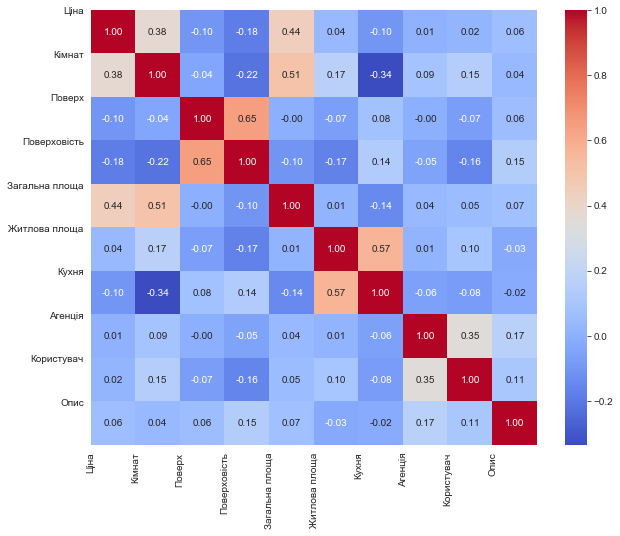

In [1050]:
corr = df_real_estate.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [1051]:
df_real_estate['z_score']=stats.zscore(df_real_estate['Ціна'])

In [1052]:
df_real_estate = df_real_estate.loc[df_real_estate['z_score'].abs() <= 6.5]

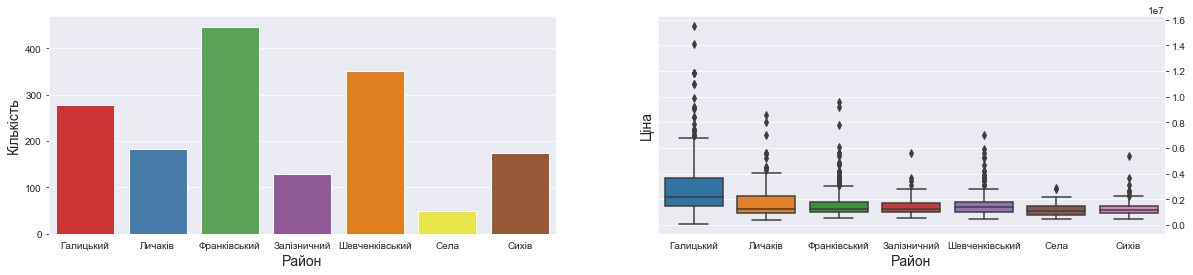

In [1053]:
f, axes = plt.subplots(1,2,figsize=(20,4))

sns.countplot(df_real_estate['Район'], ax = axes[0], palette="Set1")
axes[0].set_xlabel('Район', fontsize=14)
axes[0].set_ylabel('Кількість', fontsize=14)
axes[0].yaxis.tick_left()

sns.boxplot(x=df_real_estate['Район'], y=df_real_estate['Ціна'], data=dataset, ax=axes[1])
axes[1].set_xlabel('Район', fontsize=14)
axes[1].set_ylabel('Ціна', fontsize=14)
axes[1].yaxis.tick_right()

plt.show()

In [1054]:
df_real_estate = df_real_estate.drop(['Стіни', 'Агенція', 'Поверх', 'Житлова площа', 'Поверховість', 'Кухня'], axis=1)

In [1055]:
df_real_estate.count()

Район             1612
Ціна              1612
Кімнат            1612
Загальна площа    1612
Користувач        1612
Опис              1612
z_score           1612
dtype: int64

We have quite a lot of `NaN` values.\
Let us suppose, how we can replace them.\
The `street` we can guess out of the `district` or replace with a median of this column.\
The `description` we can convert into the number of words.\
\
The `agency` and the `user` we can try to predict. Out of one another. And then convert them into dummy values, ageny - 1, a person - 0.\
\
The last, but not the least, we have two nomerous columns: `house area` and `kitchen`, that must have the replacement of the `NaN`'s to the number.\
We can replace the values with `mean` | `median` | `KNN value` | `MICE predicted value`. We'll see what works better.\


In [1056]:
df_real_estate.describe()

,Ціна,Кімнат,Загальна площа,Користувач,Опис,z_score
count,1.612000e+03,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000
mean,1.797019e+06,2.145161,69.427481,0.808933,20.725186,-0.029493
std,1.469034e+06,1.042258,36.909314,0.393264,37.724534,0.678216
min,7.000000e+04,1.000000,2.000000,0.000000,0.000000,-0.826814
25%,1.010944e+06,1.000000,45.000000,1.000000,0.000000,-0.392404
50%,1.323520e+06,2.000000,62.000000,1.000000,0.000000,-0.248096
75%,2.027520e+06,3.000000,81.000000,1.000000,29.250000,0.076923
max,1.548800e+07,8.000000,514.000000,1.000000,287.000000,6.291284


In [1057]:
df_real_estate.isnull().sum()

Район             0
Ціна              0
Кімнат            0
Загальна площа    0
Користувач        0
Опис              0
z_score           0
dtype: int64

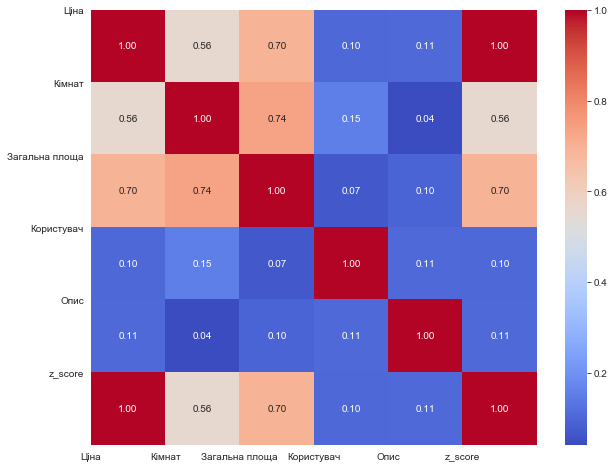

In [1058]:
corr = df_real_estate.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

So, now we can see that the `price` of the houses really depends on the `number of rooms`, the `general area` of the flat.\
There is a bit the `description` takes part.

In [1059]:
df_real_estate = pd.get_dummies(df_real_estate)

In [1060]:
df_real_estate.head()

,Ціна,Кімнат,Загальна площа,Користувач,Опис,z_score,Район_Галицький,Район_Залізничний,Район_Личаків,Район_Села,Район_Сихів,Район_Франківський,Район_Шевченківський
0,1070080.0,2,51.10,1,53,-0.365102,1,0,0,0,0,0,0
1,983614.0,2,65.14,1,208,-0.405022,0,0,1,0,0,0,0
2,583730.0,1,37.66,1,222,-0.589638,0,0,1,0,0,0,0
3,613211.0,1,40.61,1,238,-0.576027,0,0,1,0,0,0,0
4,628160.0,1,41.60,1,234,-0.569126,0,0,1,0,0,0,0


In [1061]:
df_real_estate = df_real_estate.drop(['z_score'], axis=1)

In [1062]:
X = df_real_estate.drop('Ціна', axis = 1).values
y = df_real_estate['Ціна'].values.reshape(-1,1)

In [1063]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.25, random_state=1)

In [1064]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of X_val: ",X_val.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_val",y_val.shape)

Shape of X_train:  (966, 11)
Shape of X_test:  (323, 11)
Shape of X_val:  (323, 11)
Shape of y_train:  (966, 1)
Shape of y_test (323, 1)
Shape of y_val (323, 1)


### Regression Models

In [1065]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predictions')

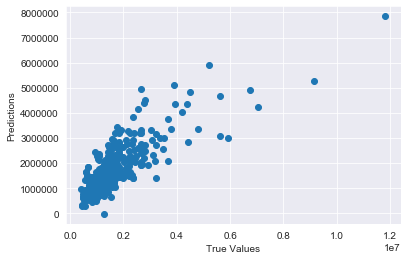

In [1066]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [1067]:
print('Score:', model.score(X_test, y_test))

Score: 0.6446068973843868


In [1081]:
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator=lm, X=X, y=y, cv=8)

# Predicting R2 Score the Train set results
y_pred_linear_train = lm.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = lm.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# Predicting RMSE the Test set results
# Root Mean Squere Error
rmse_linear = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_linear)

CV:  0.5166458569258392
R2_score (train):  0.555436892893958
R2_score (test):  0.6446068973843868
RMSE:  733042.3601619711


In [1069]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [1070]:
train_error, test_error = calc_metrics(X_train, y_train, X_test, y_test, lm)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 1140640583941.591 | test error: 537351101791.833
train/test: 0.5


In [1072]:
# delete intermediate variables
# del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df_real_estate['Ціна']),2),
                                                       round(len(y_val)/len(df_real_estate['Ціна']),2),
                                                       round(len(y_test)/len(df_real_estate['Ціна']),2)))

train: 0.6% | validation: 0.2% | test 0.2%
